In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
%matplotlib inline 

import matplotlib.patches as mpatches
from skimage import io as skimgIO
from skimage.filters import (sobel, threshold_otsu)
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rotate,
                               hough_circle, hough_circle_peaks)
from skimage.exposure import histogram
from skimage.feature import canny, corner_harris, corner_peaks, corner_subpix, hog
from skimage.color import (rgb2gray, label2rgb)
from skimage.measure import (label, regionprops)
from skimage import morphology

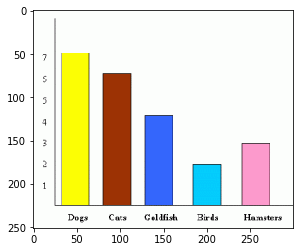

In [12]:
img_path = './data_test/bar_img_failed/real_bar_7.png'
img_ori = skimgIO.imread(img_path)   #<class 'imageio.core.util.Array'>
#plt.imshow(img_ori)
type(img_ori.dtype)
plt.imshow(img_ori)

<class 'numpy.ndarray'> float64
0.7113964031862745
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


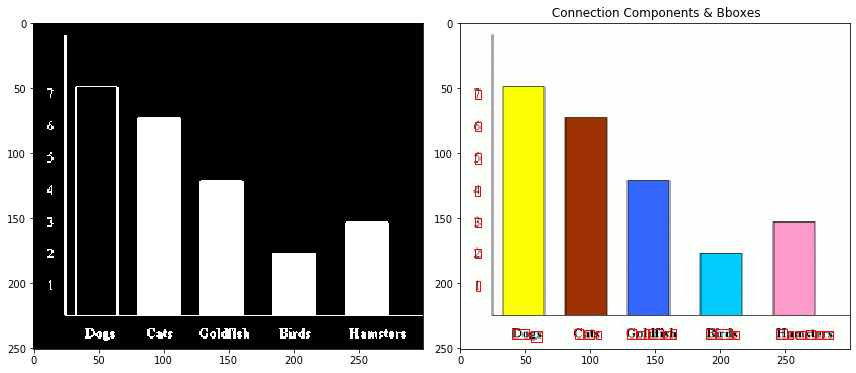

In [13]:
img_gray = rgb2gray(img_ori)   #<class 'numpy.ndarray'>
print(type(img_gray), img_gray.dtype)
# 二值化
thresh = threshold_otsu(img_gray)
print(thresh)
img_binary = img_gray < thresh
print(img_binary)

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.ravel()
ax[0].imshow(img_binary, cmap=c_map.gray)

label_img, label_num = label(img_binary, background=None, return_num=True, connectivity=2)
#image_label_overlay = label2rgb(label_img, image=img_binary)
#plt.imshow(image_label_overlay)

chara_bbox_cent = []
chara_bbox = []
chara_bbox_area = []
label_rm = []
img_height, img_width = img_binary.shape

ax[1].imshow(img_ori)
# see https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations
for region in regionprops(label_img):  # remove warning in 0.14 vs 0.16
    # take regions with large enough areas
    if (img_height*img_width) // 100 >= region.bbox_area >= 12 \
            and (region.major_axis_length < 10.0 * region.minor_axis_length):
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)

        chara_bbox_cent.append(region.centroid)
        chara_bbox.append(region.bbox)
        chara_bbox_area.append(region.bbox_area)
        ax[1].add_patch(rect)
    else:
        label_rm.append(region.label)

plt.title(' Connection Components & Bboxes')
#ax.set_axis_off()
# plt.savefig(name)
plt.tight_layout()

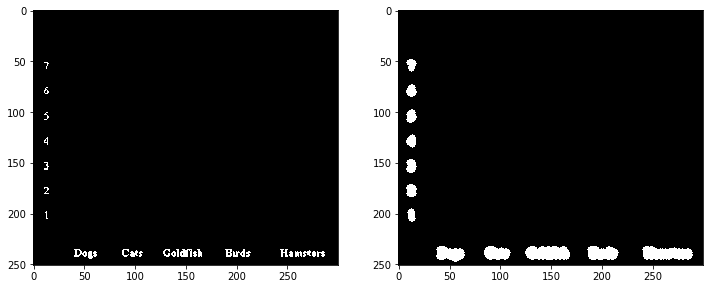

In [14]:
# 将去除干扰元素后的字母元素提取出来
label_rm.append(0)
img_crop = np.isin(label_img, label_rm, invert=True)
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax = ax.ravel()
ax[0].imshow(img_crop, cmap=c_map.gray)

# 腐蚀操作
kernel = morphology.disk(3)
img_dialtion = morphology.dilation(img_crop, kernel)

ax[1].imshow(img_dialtion, cmap=c_map.gray)

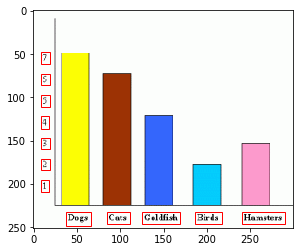

In [15]:
# 腐蚀后再次连通域检测
label_txt, label_num = label(img_dialtion, background=None, return_num=True, connectivity=2)

txt_bbox_cent = []
txt_bbox = []

fig, ax = plt.subplots()
ax.imshow(img_ori)
# see https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations
for region in regionprops(label_txt):  # remove warning in 0.14 vs 0.16
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    txt_bbox_cent.append(region.centroid)
    txt_bbox.append(region.bbox)
    ax.add_patch(rect)
    
